In [4]:
import gc
import os
import time
import warnings
from itertools import combinations
from warnings import simplefilter

import joblib
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle" # https://drive.google.com/drive/folders/18KshTFZ6gGQMeqUf5N6FZq2H1P9fNYlB?usp=sharing

In [3]:
!kaggle competitions download optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip

100% 201M/201M [00:07<00:00, 29.8MB/s]
100% 201M/201M [00:07<00:00, 27.9MB/s]
Archive:  optiver-trading-at-the-close.zip
  inflating: example_test_files/revealed_targets.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/test.csv  
  inflating: optiver2023/__init__.py  
  inflating: optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: public_timeseries_testing_util.py  
  inflating: train.csv               


In [19]:
df = pd.read_csv("/content/train.csv")

In [7]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    return df

from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            if mid_val == min_val:  # Prevent division by zero
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features


def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

# generate imbalance features
def imbalance_features(df):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    # V2
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']

    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)

    # V3
    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size',
                'wap', 'near_price', 'far_price']:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    return df.replace([np.inf, -np.inf], 0)

# generate time & stock features
def other_features(df):
    df["dow"] = df["date_id"] % 5
    df["dom"] = df["date_id"] % 20
    df["seconds"] = df["seconds_in_bucket"] % 60
    df["minute"] = df["seconds_in_bucket"] // 60

    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

# generate all features
def generate_all_features(df):
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    df = imbalance_features(df)
    df = other_features(df)
    gc.collect()

    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]

    return df[feature_name]

weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04, 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

weights = {int(k):v for k,v in enumerate(weights)}

In [8]:
global_stock_id_feats = {
        "median_size": df.groupby("stock_id")["bid_size"].median() + df.groupby("stock_id")["ask_size"].median(),
        "std_size": df.groupby("stock_id")["bid_size"].std() + df.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df.groupby("stock_id")["bid_size"].max() - df.groupby("stock_id")["bid_size"].min(),
        "median_price": df.groupby("stock_id")["bid_price"].median() + df.groupby("stock_id")["ask_price"].median(),
        "std_price": df.groupby("stock_id")["bid_price"].std() + df.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df.groupby("stock_id")["bid_price"].max() - df.groupby("stock_id")["ask_price"].min(),
  }

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split

def imputer(df):
    far_price_mean = df['far_price'].mean()
    near_price_mean = df['near_price'].mean()
    df['far_price'] = df['far_price'].fillna(far_price_mean)
    df['near_price'] = df['near_price'].fillna(near_price_mean)

    return df, far_price_mean, near_price_mean

def add_missing_data(df):
    all_stock_ids = set(range(200))
    all_missed_data_list = []
    grouped = df.groupby('time_id')

    for t, group in grouped:
        current_stock_ids = set(group['stock_id'].to_list())
        missed_stock_id = list(all_stock_ids - current_stock_ids)

        date_id = group['date_id'].iloc[-1]
        seconds_in_bucket = group['seconds_in_bucket'].iloc[-1]

        missed_stock_id_num = len(missed_stock_id)
        missed_date_id = [date_id] * missed_stock_id_num
        missed_seconds_in_bucket = [seconds_in_bucket] * missed_stock_id_num
        missed_time_id = [t] * missed_stock_id_num

        missed_data = pd.DataFrame({
            'stock_id': missed_stock_id,
            'date_id': missed_date_id,
            'seconds_in_bucket': missed_seconds_in_bucket,
            'time_id': missed_time_id
        })

        all_missed_data_list.append(missed_data)

    all_missed_data = pd.concat(all_missed_data_list, axis=0).reset_index(drop=True).astype(int)

    df = pd.concat([df, all_missed_data], axis=0)
    df = df.sort_values(by=['time_id', 'stock_id']).reset_index(drop=True)
    df = df.groupby('stock_id').apply(lambda x: x.fillna(method='bfill')).reset_index(drop=True)

    return df

def sizesum_and_pricestd(df):
    price_ftrs = ['reference_price', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap'] # std
    size_ftrs = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size'] # sum

    rolled = df[['stock_id'] + size_ftrs].groupby('stock_id').rolling(window=6, min_periods=1).sum()
    rolled = rolled.reset_index(level=0, drop=True)
    for col in size_ftrs:
        df[f'{col}_rolled_sum'] = rolled[col]

    rolled = df[['stock_id'] + price_ftrs].groupby('stock_id').rolling(window=6, min_periods=1).std().fillna(0)
    rolled = rolled.reset_index(level=0, drop=True)
    for col in price_ftrs:
        df[f'{col}_rolled_std'] = rolled[col]

    return df

def remove_element(input_list, drop_list):
    return [e for e in input_list if e not in drop_list]

train, far_price_mean, near_price_mean = imputer(df)
train = add_missing_data(df)
train = sizesum_and_pricestd(train)

no_feature_cols = ['date_id', 'row_id', 'time_id', 'target', 'currently_scored']
feature_cols = remove_element(train.columns, no_feature_cols)

avg = train[feature_cols].mean()
std = train[feature_cols].std()

train[feature_cols] = (train[feature_cols] - avg)/std

train = train.astype('float32')

csv_file_path = "preprocessed_data.csv"
train.to_csv(csv_file_path, index=False)

seq_len = 16

grouped_by_time = train.groupby('stock_id')

def generate_data(grouped_by_time, seq_len):
    for _, group in grouped_by_time:
        group_sorted = group.sort_values(by='time_id')
        features = group_sorted[feature_cols].values

        windows = []

        for t in range(0, seq_len - 1):
            copy_0 = np.stack([features[0]] * (seq_len - 1 - t))
            cut_0 = features[: t + 1]
            windows.append(np.vstack((copy_0, cut_0)))

        for t in range(0, features.shape[0] - seq_len + 1):
            windows.append(features[t: t+seq_len, :])

        features_array = np.stack(windows)
        target = group_sorted['target'].values

        yield features_array, target

data_generator = generate_data(grouped_by_time, seq_len=seq_len)

datas, labels = zip(*data_generator)
data = np.array(datas).reshape(-1, seq_len, len(feature_cols))
label = np.array(labels).reshape(-1,)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

data = torch.tensor(data, dtype=torch.float32).to(device)
label = torch.tensor(label, dtype=torch.float32).to(device)

dataset = TensorDataset(data, label)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

batch_size = 4096

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# # Define Series Decomposition Module
# class SeriesDecomposition(nn.Module):
#     def __init__(self, window_size):
#         super(SeriesDecomposition, self).__init__()
#         self.window_size = window_size
#         padding = (window_size - 1) // 2
#         self.avg_pool = nn.AvgPool1d(window_size, stride=1, padding=padding, count_include_pad=False)

#     def forward(self, x):
#         x_pooled = x.transpose(1, 2)
#         trend = self.avg_pool(x_pooled)
#         trend = trend.transpose(1, 2)
#         if trend.shape[1] < x.shape[1]:
#             pad_size = x.shape[1] - trend.shape[1]
#             trend = F.pad(trend, (0, 0, 0, pad_size), "constant", 0)
#         seasonal = x - trend
#         return trend, seasonal

# # Define AutoCorrelation Module
# class AutoCorrelation(nn.Module):
#     def __init__(self):
#         super(AutoCorrelation, self).__init__()

#     def forward(self, x):
#         batch_size, seq_len, features = x.shape
#         x_mean = x.mean(dim=1, keepdim=True)
#         x = x - x_mean
#         result = torch.bmm(x, x.transpose(1, 2)) / seq_len
#         return result

# class AutoformerEncoderLayer(nn.Module):
#     def __init__(self, d_model, nhead, window_size, feature_dim):
#         super(AutoformerEncoderLayer, self).__init__()
#         self.decomposition = SeriesDecomposition(window_size)
#         self.auto_corr = AutoCorrelation()
#         self.linear = nn.Linear(feature_dim, d_model)  # Correct feature_dim to d_model
#         self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)

#     def forward(self, x):
#         print(x.shape)
#         trend, seasonal = self.decomposition(x)
#         seasonal_corr = self.auto_corr(seasonal)
#         # Flatten the batch and sequence length dimensions
#         batch_size, seq_len, _ = seasonal_corr.shape
#         seasonal_corr_flat = seasonal_corr.view(batch_size * seq_len, -1)
#         transformed = self.linear(seasonal_corr_flat)
#         # Reshape back to (batch_size, seq_len, d_model)
#         transformed = transformed.view(batch_size, seq_len, -1)
#         return self.transformer_encoder_layer(transformed)

# class AutoformerEncoder(nn.Module):
#     def __init__(self, d_model, nhead, num_layers, window_size, feature_dim):
#         super(AutoformerEncoder, self).__init__()
#         self.layers = nn.ModuleList([AutoformerEncoderLayer(d_model, nhead, window_size, feature_dim) for _ in range(num_layers)])

#     def forward(self, x):
#         for layer in self.layers:
#             x = layer(x)
#         return x

# class AutoformerDecoderLayer(nn.Module):
#     def __init__(self, d_model, nhead, window_size, feature_dim):
#         super(AutoformerDecoderLayer, self).__init__()
#         self.decomposition = SeriesDecomposition(window_size)
#         self.auto_corr = AutoCorrelation()
#         self.linear = nn.Linear(feature_dim, d_model)  # Make sure feature_dim is 23
#         self.transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

#     def forward(self, x, memory):
#         trend, seasonal = self.decomposition(x)
#         seasonal_corr = self.auto_corr(seasonal)
#         # Flatten the batch and sequence length dimensions
#         seasonal_corr_flat = seasonal_corr.view(-1, seasonal_corr.size(-1))
#         transformed = self.linear(seasonal_corr_flat)
#         # Reshape back to (batch_size, seq_len, d_model)
#         transformed = transformed.view(x.size(0), x.size(1), -1)
#         return self.transformer_decoder_layer(transformed, memory)

# # Define Autoformer Decoder
# class AutoformerDecoder(nn.Module):
#     def __init__(self, d_model, nhead, num_layers, window_size, feature_dim):
#         super(AutoformerDecoder, self).__init__()
#         self.layers = nn.ModuleList([AutoformerDecoderLayer(d_model, nhead, window_size, feature_dim) for _ in range(num_layers)])

#     def forward(self, x, memory):
#         for layer in self.layers:
#             x = layer(x, memory)
#         return x

# # Define the complete Autoformer Model
# class Autoformer(nn.Module):
#     def __init__(self, num_features, d_model, nhead, num_layers, window_size):
#         super(Autoformer, self).__init__()
#         self.encoder = AutoformerEncoder(d_model, nhead, num_layers, window_size, num_features)
#         self.decoder = AutoformerDecoder(d_model, nhead, num_layers, window_size, num_features)
#         self.linear = nn.Linear(d_model, 1)

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded, encoded)
#         out = self.linear(decoded[:, -1, :])
#         return out

# # Define the wrapper Model
# class AutoformerModel(nn.Module):
#     def __init__(self, feature_num, d_model, nhead, num_layers, window_size):
#         super(AutoformerModel, self).__init__()
#         self.autoformer = Autoformer(feature_num, d_model, nhead, num_layers, window_size)
#         self.decoder = nn.Linear(d_model, 1)

#     def forward(self, x):
#         x = self.autoformer(x)
#         x = x[:, -1, :]
#         return self.decoder(x)


In [ ]:
# from transformers import AutoformerConfig, AutoformerModel

# class MyAutoformerModel(nn.Module):
#     def __init__(self, feature_num, d_model, nhead, num_layers):
#         super(MyAutoformerModel, self).__init__()
#         self.embedding = nn.Linear(feature_num, d_model)

#         # Configure the Autoformer model
#         self.config = AutoformerConfig(
#             d_model=d_model,  # Embedding dimension
#             nhead=nhead,      # Number of attention heads
#             num_encoder_layers=num_layers,  # Number of encoder layers
#             gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
#             prediction_length=1,
#             batch_first=True
#         )

#         self.autoformer = AutoformerModel(self.config)

#         self.fc = nn.Linear(d_model, d_model)
#         self.dropout = nn.Dropout(0.5)
#         self.decoder = nn.Linear(d_model, 1)

#     def forward(self, x, past_time_features=None, past_observed_mask=None):
#         x = self.embedding(x)

#         # Process input through Autoformer
#         outputs = self.autoformer(x, past_time_features, past_observed_mask)
#         last_hidden_states = outputs.last_hidden_state

#         # Select the last output for prediction
#         x = last_hidden_states[:, -1, :]

#         x = self.fc(x)
#         x = self.dropout(x)
#         x = self.decoder(x)

#         return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Transformer(nn.Module):
    def __init__(self, feature_num, d_model, nhead, num_layers):
        super(MyModel, self).__init__()
        self.embedding = nn.Linear(feature_num, d_model)
        self.tf1 = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.5)
        self.tf2 = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):does
        x = self.embedding(x)
        x = self.tf1.encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        x = self.tf2.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
import math

tot_train_losses = []
tot_train_mae = []
tot_train_rmse = []
tot_train_rmsle = []

tot_valid_losses = []
tot_valid_mae = []
tot_valid_rmse = []
tot_valid_rmsle = []

is_train = True
if is_train:
    input_size = data.shape[-1]

    n_epochs = 50
    lr = 1e-03

    pre_epoch_valid_mae = np.inf
    patience_counter = 0

    model = Transformer(feature_num=input_size, d_model=64, nhead=8, num_layers=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss = nn.L1Loss().to(device)

    out_path = "model/"
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    best_mae = np.inf

    print(f'Train start...')
    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        train_mae = []
        train_rmse = []
        batch_num = len(train_loader)

        # Training
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X).squeeze()
            l = loss(outputs, y)
            l.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            train_losses.append(l.item())

            # Calculate MAE
            mae = mean_absolute_error(y.cpu().numpy(), outputs.detach().cpu().numpy())
            train_mae.append(mae)

            # Calculate RMSE
            rmse = math.sqrt(mean_squared_error(y.cpu().numpy(), outputs.detach().cpu().numpy()))
            train_rmse.append(rmse)

        epoch_train_loss = np.mean(train_losses)
        epoch_train_mae = np.mean(train_mae)
        epoch_train_rmse = np.mean(train_rmse)

        tot_train_losses.append(epoch_train_loss)
        tot_train_mae.append(epoch_train_mae)
        tot_train_rmse.append(epoch_train_rmse)

        print(f'Epoch [{epoch+1}/{n_epochs}] Training Loss: {epoch_train_loss:.4f}')
        print(f'Epoch [{epoch+1}/{n_epochs}] Training MAE: {epoch_train_mae:.4f}')
        print(f'Epoch [{epoch+1}/{n_epochs}] Training RMSE: {epoch_train_rmse:.4f}')

        train_maes = []

        model.eval()
        with torch.no_grad():
            valid_losses = []
            valid_maes = []
            valid_rmse = []
            valid_rmsle = []

            for X_v, y_v in valid_loader:
                preds = model(X_v).squeeze()
                valid_loss = loss(preds, y_v)
                valid_losses.append(valid_loss.item())

                # Calculate MAE
                valid_mae = mean_absolute_error(y_v.cpu().numpy(), preds.cpu().numpy())
                valid_maes.append(valid_mae)

                # Calculate RMSE
                valid_rmse_val = math.sqrt(mean_squared_error(y_v.cpu().numpy(), preds.cpu().numpy()))
                valid_rmse.append(valid_rmse_val)

            epoch_valid_loss = np.mean(valid_losses)
            epoch_valid_mae = np.mean(valid_maes)
            epoch_valid_rmse = np.mean(valid_rmse)

            tot_valid_losses.append(epoch_train_loss)
            tot_valid_mae.append(epoch_train_mae)
            tot_valid_rmse.append(epoch_train_rmse)

            print(f'Epoch [{epoch+1}/{n_epochs}] Validation Loss: {epoch_valid_loss:.4f}')
            print(f'Epoch [{epoch+1}/{n_epochs}] Validation MAE: {epoch_valid_mae:.4f}')
            print(f'Epoch [{epoch+1}/{n_epochs}] Validation RMSE: {epoch_valid_rmse:.4f}')


            if epoch_valid_mae < best_mae:
                best_mae = epoch_valid_mae
                torch.save(model, os.path.join(out_path, f"model_epoch_{epoch+1}.pt"))

        if epoch_valid_mae - pre_epoch_valid_mae > 0:
            patience_counter += 1

            if patience_counter == 2:
                lr = lr * 0.5
                patience_counter = 0
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                    print(f'renew lr to {lr}')

        pre_epoch_valid_mae = epoch_valid_mae

        if (epoch_valid_mae - epoch_train_mae > 0.03) or (lr <1e-7):
            print('Early stop now.')
            break

    print(f'Train over.')

Train start...
Epoch [1/50] Training Loss: 6.3467
Epoch [1/50] Training MAE: 6.3467
Epoch [1/50] Training RMSE: 9.4358
Epoch [1/50] Validation Loss: 6.2791
Epoch [1/50] Validation MAE: 6.2791
Epoch [1/50] Validation RMSE: 9.3254
Epoch [2/50] Training Loss: 6.2780
Epoch [2/50] Training MAE: 6.2780
Epoch [2/50] Training RMSE: 9.3340
Epoch [2/50] Validation Loss: 6.2669
Epoch [2/50] Validation MAE: 6.2669
Epoch [2/50] Validation RMSE: 9.3041
Epoch [3/50] Training Loss: 6.2611
Epoch [3/50] Training MAE: 6.2611
Epoch [3/50] Training RMSE: 9.2963
Epoch [3/50] Validation Loss: 6.2399
Epoch [3/50] Validation MAE: 6.2399
Epoch [3/50] Validation RMSE: 9.2491
Epoch [4/50] Training Loss: 6.2375
Epoch [4/50] Training MAE: 6.2375
Epoch [4/50] Training RMSE: 9.2578
Epoch [4/50] Validation Loss: 6.2303
Epoch [4/50] Validation MAE: 6.2303
Epoch [4/50] Validation RMSE: 9.2390
Epoch [5/50] Training Loss: 6.2315
Epoch [5/50] Training MAE: 6.2315
Epoch [5/50] Training RMSE: 9.2508
Epoch [5/50] Validation L

In [ ]:
torch.save(model.state_dict(), os.path.join(out_path, "time_series_transformer.pt"))

In [ ]:
import pickle

metrics = {
    "Train Loss": tot_train_losses,
    "Train MAE": tot_train_mae,
    "Train RMSE": tot_train_rmse,
    "Validation Loss": tot_valid_losses,
    "Validation MAE": tot_valid_mae,
    "Validation RMSE": tot_valid_rmse
}

with open('transformer_training_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('transformer_training_metrics.csv', index=False)

In [5]:
metrics_df = pd.read_csv('transformer_training_metrics.csv')
metrics_df

,Train Loss,Train MAE,Train RMSE,Validation Loss,Validation MAE,Validation RMSE
0,6.346697,6.346698,9.435811,6.346697,6.346698,9.435811
1,6.277980,6.277979,9.334006,6.277980,6.277979,9.334006
2,6.261107,6.261108,9.296279,6.261107,6.261108,9.296279
3,6.237513,6.237513,9.257776,6.237513,6.237513,9.257776
4,6.231481,6.231481,9.250779,6.231481,6.231481,9.250779
5,6.227334,6.227334,9.245218,6.227334,6.227334,9.245218
6,6.223273,6.223273,9.240061,6.223273,6.223273,9.240061
7,6.220537,6.220537,9.236355,6.220537,6.220537,9.236355
8,6.217725,6.217725,9.232065,6.217725,6.217725,9.232065
9,6.215702,6.215702,9.229430,6.215702,6.215702,9.229430


In [8]:
metrics_df.min()

Train Loss         6.147857
Train MAE          6.147857
Train RMSE         9.133104
Validation Loss    6.147857
Validation MAE     6.147857
Validation RMSE    9.133104
dtype: float64

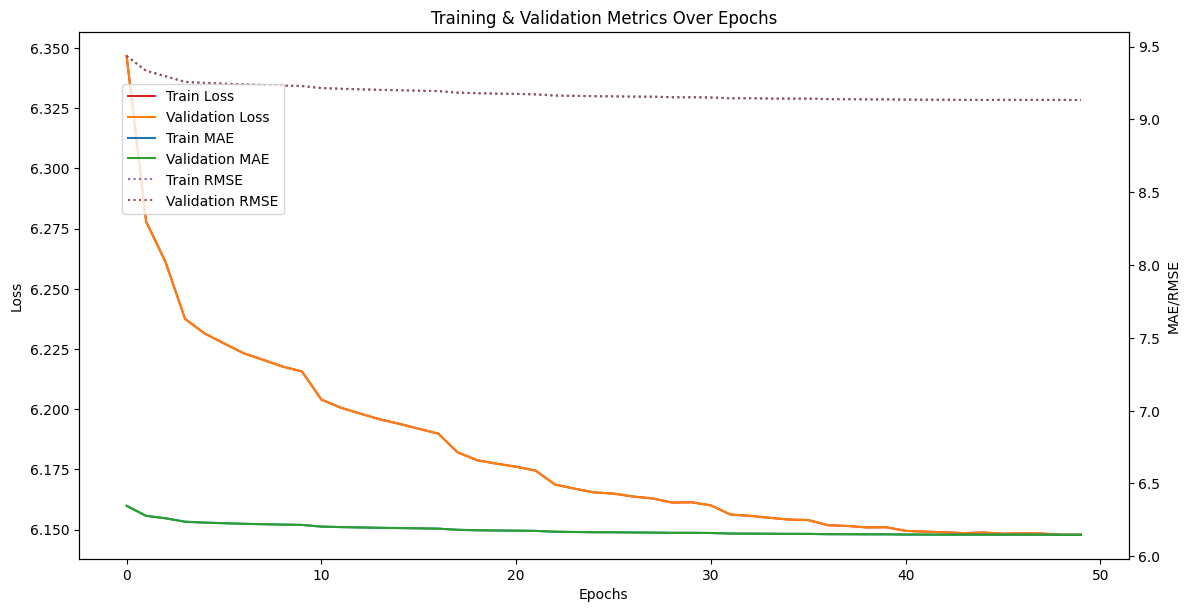

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting training and validation loss
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(tot_train_losses, label='Train Loss', color='tab:red')
ax1.plot(tot_valid_losses, label='Validation Loss', color='tab:orange')
ax1.tick_params(axis='y')

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('MAE/RMSE')
ax2.plot(tot_train_mae, label='Train MAE', color='tab:blue')
ax2.plot(tot_valid_mae, label='Validation MAE', color='tab:green')
ax2.plot(tot_train_rmse, label='Train RMSE', color='tab:purple', linestyle='dotted')
ax2.plot(tot_valid_rmse, label='Validation RMSE', color='tab:brown', linestyle='dotted')
ax2.tick_params(axis='y')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Training & Validation Metrics Over Epochs')
plt.show()

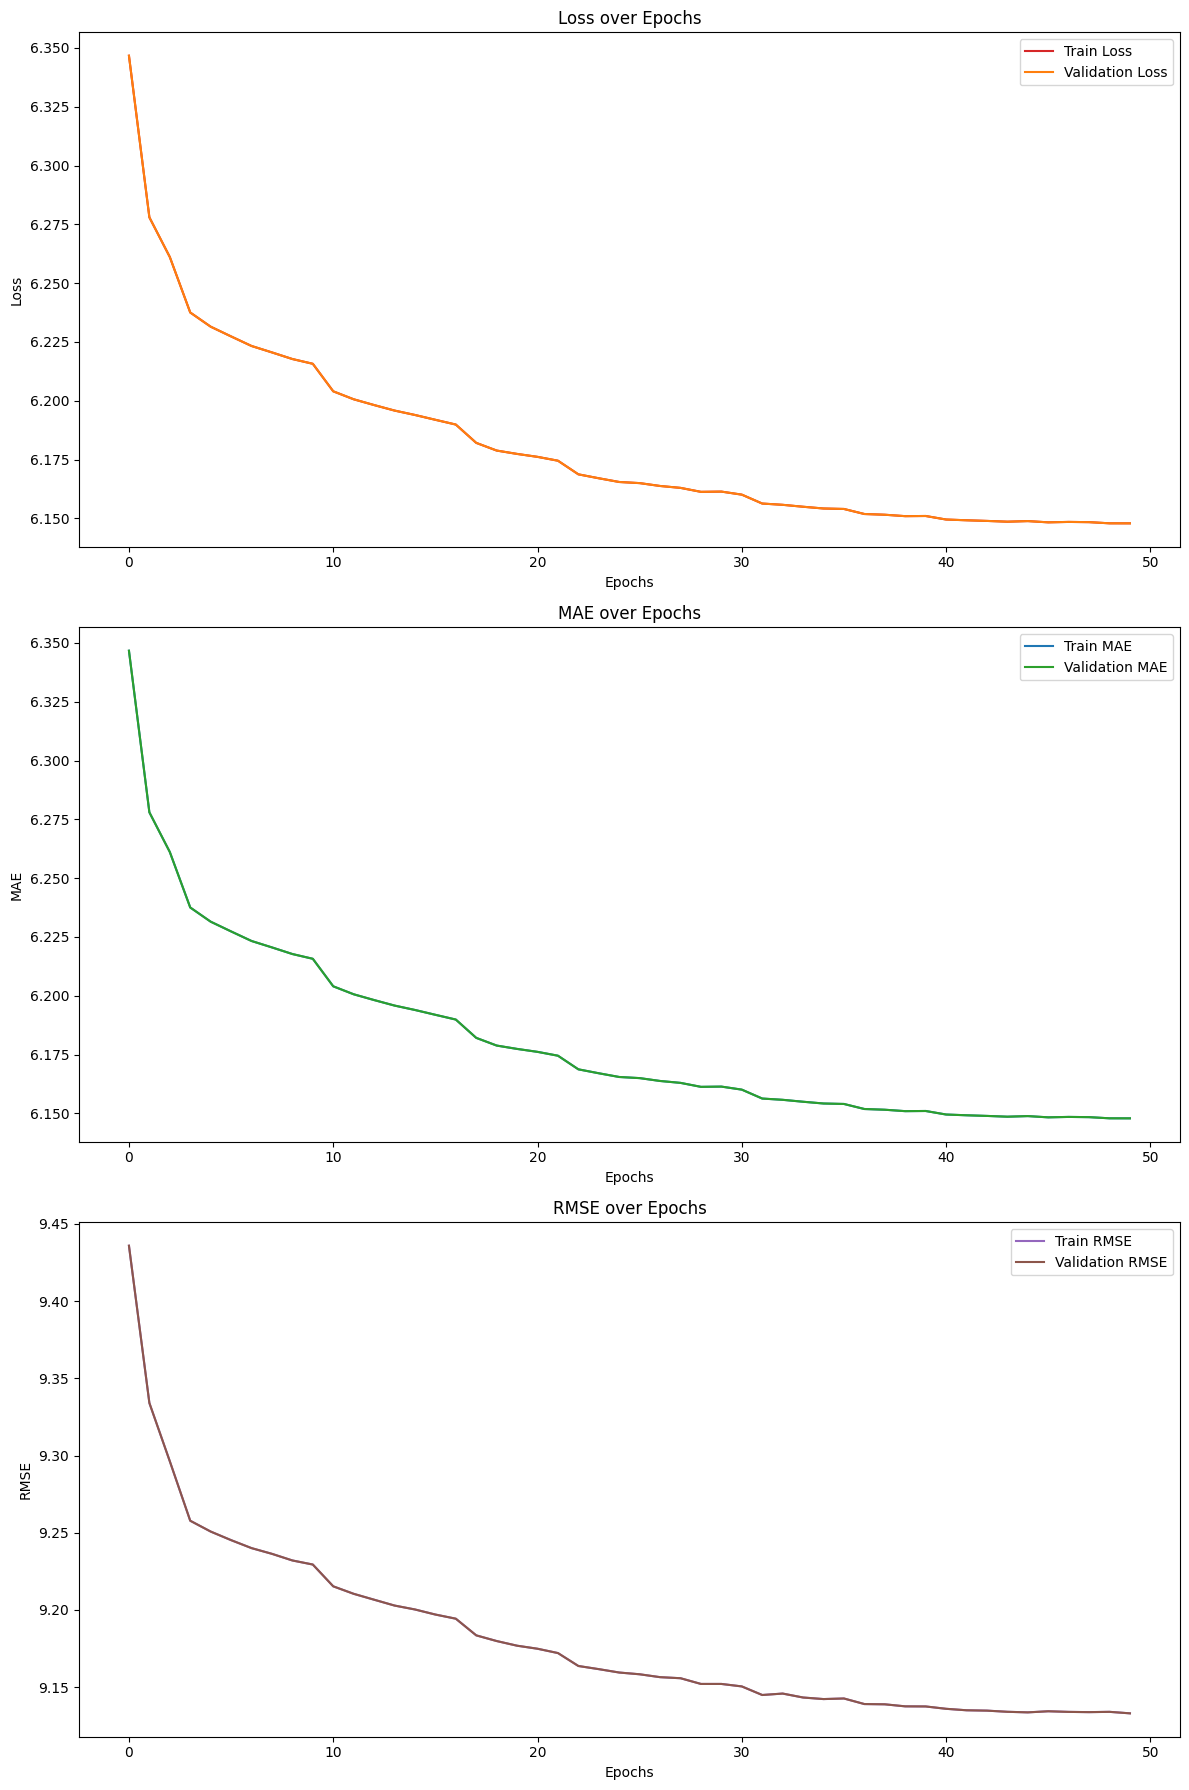

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Loss subplot
axs[0].plot(tot_train_losses, label='Train Loss', color='tab:red')
axs[0].plot(tot_valid_losses, label='Validation Loss', color='tab:orange')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MAE subplot
axs[1].plot(tot_train_mae, label='Train MAE', color='tab:blue')
axs[1].plot(tot_valid_mae, label='Validation MAE', color='tab:green')
axs[1].set_title('MAE over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

# RMSE subplot
axs[2].plot(tot_train_rmse, label='Train RMSE', color='tab:purple')
axs[2].plot(tot_valid_rmse, label='Validation RMSE', color='tab:brown')
axs[2].set_title('RMSE over Epochs')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('RMSE')
axs[2].legend()

plt.tight_layout()
plt.show()


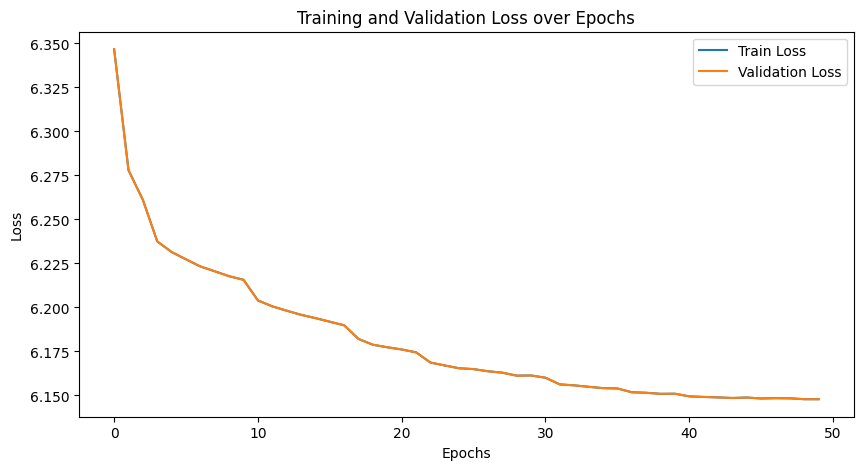

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

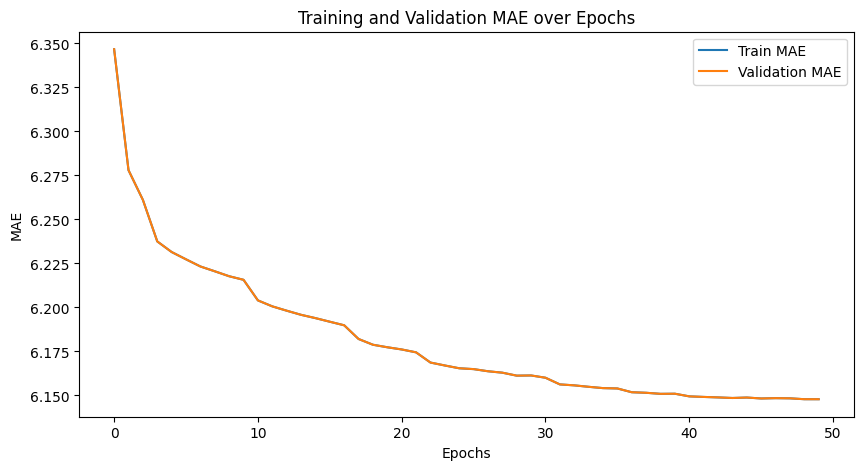

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

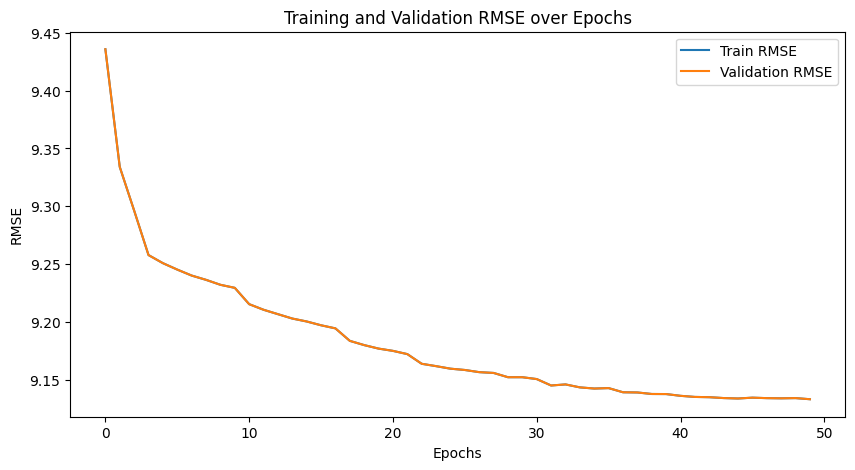

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Training and Validation RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


features_tensor = torch.tensor(scaled_features, dtype=torch.float32)
target_tensor = torch.tensor(df['target'].values, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(features_tensor, target_tensor, test_size=0.2, random_state=42)

In [ ]:
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        # Add a dummy sequence length dimension to features
        self.features = features.unsqueeze(1)  # Add a dimension of size 1 at position 1
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx].to(device), self.targets[idx].to(device)


train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)


class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, num_layers=2, d_model=48, nhead=2, dim_feedforward=128, dropout=0.05):
        super(TimeSeriesTransformer, self).__init__()
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_layers,
            dim_feedforward=dim_feedforward, dropout=dropout)
        self.linear_in = nn.Linear(num_features, d_model)
        self.linear_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.linear_in(src)  # shape: [batch_size, seq_len, d_model]
        src = src.permute(1, 0, 2)  # shape: [seq_len, batch_size, d_model]
        output = self.transformer(src, src)
        output = output.permute(1, 0, 2)  # shape: [batch_size, seq_len, d_model]
        output = self.linear_out(output[:, -1, :])  # Only take the output of the last time step
        return output

# Initialize the model
model = TimeSeriesTransformer(num_features=X_train.shape[1]).to(device)

# Define Loss Function and Optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

scaler = torch.cuda.amp.GradScaler()


# Training loop
for epoch in range(10):
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    for features, targets in train_loader:
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(features)
            loss = loss_function(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            val_loss += loss_function(outputs, targets).item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

Epoch 1, Loss: nan
Validation Loss: nan
Epoch 2, Loss: nan
Validation Loss: nan
Epoch 3, Loss: nan
Validation Loss: nan
Epoch 4, Loss: nan
Validation Loss: nan
Epoch 5, Loss: nan
Validation Loss: nan
Epoch 6, Loss: nan
Validation Loss: nan


KeyboardInterrupt: ignored

In [ ]:
if is_offline:
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
else:
    df_train = df
    print("Online mode")


if is_train:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    if is_offline:
        df_train_feats = generate_all_features(df_train)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        df_train_feats = generate_all_features(df_train)
        print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)

Online mode
Build Online Train Feats Finished.


In [ ]:
offline_split = df_train['date_id']>(split_day - 45)
df_offline_train = df_train_feats[~offline_split]
df_offline_valid = df_train_feats[offline_split]
df_offline_train_target = df_train['target'][~offline_split]
df_offline_valid_target = df_train['target'][offline_split]

# Check and remove NaN values
df_offline_train_target = df_offline_train_target.dropna()
df_offline_valid_target = df_offline_valid_target.dropna()

# Check and remove infinite values, if any
df_offline_train_target.replace([np.inf, -np.inf], np.nan, inplace=True)
df_offline_valid_target.replace([np.inf, -np.inf], np.nan, inplace=True)

df_offline_train_target.dropna(inplace=True)
df_offline_valid_target.dropna(inplace=True)

df_offline_train = df_offline_train.loc[df_offline_train_target.index]
df_offline_valid = df_offline_valid.loc[df_offline_valid_target.index]

In [ ]:
df_offline_train_target

0          -3.029704
1          -5.519986
2          -8.389950
3          -4.010200
4          -7.349849
             ...    
4247975   -11.060238
4247976    -0.669956
4247977    -8.400083
4247978     9.839535
4247979    -2.229810
Name: target, Length: 4247893, dtype: float64

In [ ]:
df_offline_train

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,dom,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
0,0,0,3.180603e+06,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.500000,...,0,0,0,0,42739.160156,132986.921875,5.898990e+06,1.999695,0.003353,0.017414
1,1,0,1.666039e+05,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.040039,...,0,0,0,0,25548.500000,66444.906250,6.938986e+05,1.999827,0.005588,0.029370
2,2,0,3.028799e+05,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.000000,...,0,0,0,0,26228.099609,75674.656250,1.069838e+06,2.000200,0.005333,0.051622
3,3,0,1.191768e+07,-1,1.000171,1.838975e+07,NaN,NaN,0.999999,2324.899902,...,0,0,0,0,41667.000000,93875.773438,1.928848e+06,1.999980,0.002903,0.018551
4,4,0,4.475500e+05,-1,0.999532,1.786061e+07,NaN,NaN,0.999394,16485.539062,...,0,0,0,0,34014.578125,80670.273438,1.604066e+06,1.999816,0.003717,0.017379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247975,195,540,2.770153e+06,-1,1.002324,4.081595e+07,1.000669,1.001000,1.002214,9085.000000,...,0,10,0,9,51941.550781,98218.031250,2.761659e+06,1.999930,0.003051,0.014076
4247976,196,540,1.805638e+04,1,1.001685,8.843944e+06,1.001970,1.001685,1.001400,81736.078125,...,0,10,0,9,42476.949219,78070.062500,4.596574e+05,2.000042,0.003416,0.017398
4247977,197,540,6.114539e+05,-1,1.002596,1.922484e+07,1.001626,1.002111,1.002499,41629.898438,...,0,10,0,9,30070.039062,71964.171875,1.575294e+06,1.999984,0.004696,0.020387
4247978,198,540,6.680392e+05,1,1.002832,1.102412e+08,1.003361,1.002832,1.002568,436879.093750,...,0,10,0,9,304739.250000,354682.781250,2.159163e+06,1.999917,0.003146,0.015738


In [ ]:
feature_name = list(df_train_feats.columns)

print(f"Feature length = {len(feature_name)}")

offline_split = df_train['date_id']>(split_day - 45)
df_offline_train = df_train_feats[~offline_split]
df_offline_valid = df_train_feats[offline_split]
df_offline_train_target = df_train['target'][~offline_split]
df_offline_valid_target = df_train['target'][offline_split]

# Check and remove NaN values
df_offline_train_target = df_offline_train_target.dropna()
df_offline_valid_target = df_offline_valid_target.dropna()

# Check and remove infinite values, if any
df_offline_train_target.replace([np.inf, -np.inf], np.nan, inplace=True)
df_offline_valid_target.replace([np.inf, -np.inf], np.nan, inplace=True)

df_offline_train_target.dropna(inplace=True)
df_offline_valid_target.dropna(inplace=True)

df_offline_train = df_offline_train.loc[df_offline_train_target.index]
df_offline_valid = df_offline_valid.loc[df_offline_valid_target.index]

feature_name = [col for col in feature_name if col in df_offline_train.columns]


Feature length = 147


In [ ]:
df_offline_train

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,dom,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
0,0,0,3.180603e+06,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.500000,...,0,0,0,0,42739.160156,132986.921875,5.898990e+06,1.999695,0.003353,0.017414
1,1,0,1.666039e+05,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.040039,...,0,0,0,0,25548.500000,66444.906250,6.938986e+05,1.999827,0.005588,0.029370
2,2,0,3.028799e+05,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.000000,...,0,0,0,0,26228.099609,75674.656250,1.069838e+06,2.000200,0.005333,0.051622
3,3,0,1.191768e+07,-1,1.000171,1.838975e+07,NaN,NaN,0.999999,2324.899902,...,0,0,0,0,41667.000000,93875.773438,1.928848e+06,1.999980,0.002903,0.018551
4,4,0,4.475500e+05,-1,0.999532,1.786061e+07,NaN,NaN,0.999394,16485.539062,...,0,0,0,0,34014.578125,80670.273438,1.604066e+06,1.999816,0.003717,0.017379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247975,195,540,2.770153e+06,-1,1.002324,4.081595e+07,1.000669,1.001000,1.002214,9085.000000,...,0,10,0,9,51941.550781,98218.031250,2.761659e+06,1.999930,0.003051,0.014076
4247976,196,540,1.805638e+04,1,1.001685,8.843944e+06,1.001970,1.001685,1.001400,81736.078125,...,0,10,0,9,42476.949219,78070.062500,4.596574e+05,2.000042,0.003416,0.017398
4247977,197,540,6.114539e+05,-1,1.002596,1.922484e+07,1.001626,1.002111,1.002499,41629.898438,...,0,10,0,9,30070.039062,71964.171875,1.575294e+06,1.999984,0.004696,0.020387
4247978,198,540,6.680392e+05,1,1.002832,1.102412e+08,1.003361,1.002832,1.002568,436879.093750,...,0,10,0,9,304739.250000,354682.781250,2.159163e+06,1.999917,0.003146,0.015738


In [ ]:
from sklearn.preprocessing import StandardScaler
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import gc
import torch

class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

offline_split = df_train['date_id']>(split_day - 45)
df_offline_train = df_train_feats[~offline_split]
df_offline_valid = df_train_feats[offline_split]
df_offline_train_target = df_train['target'][~offline_split]
df_offline_valid_target = df_train['target'][offline_split]

# Check and remove NaN values
df_offline_train_target = df_offline_train_target.dropna()
df_offline_valid_target = df_offline_valid_target.dropna()

# Check and remove infinite values, if any
df_offline_train_target.replace([np.inf, -np.inf], np.nan, inplace=True)
df_offline_valid_target.replace([np.inf, -np.inf], np.nan, inplace=True)

df_offline_train_target.dropna(inplace=True)
df_offline_valid_target.dropna(inplace=True)

df_offline_train = df_offline_train.loc[df_offline_train_target.index]
df_offline_valid = df_offline_valid.loc[df_offline_valid_target.index]

feature_name = [col for col in feature_name if col in df_offline_train.columns]

# Configuring the model
config = TimeSeriesTransformerConfig(
    prediction_length=1,  # Set your prediction length
    context_length=30,  # Set your context length
    input_size=len(feature_name),  # Number of features
    # ... other configurations ...
)

# Initialize the model
model = TimeSeriesTransformerModel(config)

# Prepare the dataset
sequence_length = config.context_length
prediction_length = config.prediction_length
target_column = "target"

In [ ]:
df_offline_train.shape, df_offline_train_target.shape

((4247893, 147), (4247893,))

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_train_feats)

In [ ]:
features_scaled.shape

(5237980, 147)

In [ ]:
df_train_feats.values

array([[0.0000000e+00, 0.0000000e+00, 3.1806028e+06, ..., 1.9996949e+00,
        3.3532642e-03, 1.7414000e-02],
       [1.0000000e+00, 0.0000000e+00, 1.6660391e+05, ..., 1.9998270e+00,
        5.5878628e-03, 2.9370001e-02],
       [2.0000000e+00, 0.0000000e+00, 3.0287988e+05, ..., 2.0002000e+00,
        5.3328653e-03, 5.1622000e-02],
       ...,
       [1.9700000e+02, 5.4000000e+02, 0.0000000e+00, ..., 1.9999840e+00,
        4.6962788e-03, 2.0386999e-02],
       [1.9800000e+02, 5.4000000e+02, 1.0008988e+06, ..., 1.9999170e+00,
        3.1456479e-03, 1.5737999e-02],
       [1.9900000e+02, 5.4000000e+02, 1.8842858e+06, ..., 2.0001280e+00,
        4.3249102e-03, 2.2793001e-02]], dtype=float32)

In [ ]:
df_train_feats.shape, target_tensor.shape

((5237980, 147), torch.Size([4247893]))

In [ ]:
features_tensor = torch.tensor(df_offline_train.values, dtype=torch.float32)
target_tensor = torch.tensor(df_offline_train_target.values, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(features_tensor, target_tensor, test_size=0.2, random_state=42)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Loss Function and Optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

past_time_features = X_train
past_observed_mask = torch.ones_like(X_train, dtype=torch.float32)


# Configuring the model
config = TimeSeriesTransformerConfig(
    prediction_length=1,  # Set your prediction length
    context_length=30,  # Set your context length
    input_size=len(feature_name),  # Number of features
    past_time_features=past_time_features,
    past_observed_mask=past_observed_mask
    # ... other configurations ...
)

# Initialize the model
model = TimeSeriesTransformerModel(config)

for epoch in range(10):  # Number of epochs can be adjusted
    model.train()
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features, past_time_features, past_observed_mask)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


model.eval()
with torch.no_grad():
    total_loss = 0
    for features, targets in test_loader:
        outputs = model(features, past_time_features, past_observed_mask)
        loss = loss_function(outputs, targets)
        total_loss += loss.item()
    print(f"Test Loss: {total_loss / len(test_loader)}")


RuntimeError: ignored

In [ ]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt

if is_train:
    feature_name = list(df_train_feats.columns)
    lgb_params = {
        "objective" : "mae",
        "n_estimators" : 3000,
        "num_leaves" : 128,
        "subsample" : 0.6,
        "colsample_bytree" : 0.6,
        "learning_rate" : 0.05,
        "n_jobs" : 4,
        "device" : "gpu",
        "verbosity": -1,
        "importance_type" : "gain",
    }
    xgb_params = {
        "objective": "reg:absoluteerror",  # Use regression with linear booster
        "n_estimators": 3000,
        "max_depth": 7,  # Equivalent to 'num_leaves' in LightGBM
        "subsample": 0.6,
        "colsample_bytree": 0.6,
        "learning_rate": 0.05,
        "n_jobs": 4,
        "eval_metric": "mae",
        "tree_method": "gpu_hist",  # Enable GPU support
        "verbosity": 0,  # Equivalent to 'verbosity' in LightGBM
    }

    print(f"Feature length = {len(feature_name)}")

    offline_split = df_train['date_id']>(split_day - 45)
    df_offline_train = df_train_feats[~offline_split]
    df_offline_valid = df_train_feats[offline_split]
    df_offline_train_target = df_train['target'][~offline_split]
    df_offline_valid_target = df_train['target'][offline_split]

    # Check and remove NaN values
    df_offline_train_target = df_offline_train_target.dropna()
    df_offline_valid_target = df_offline_valid_target.dropna()

    # Check and remove infinite values, if any
    df_offline_train_target.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_offline_valid_target.replace([np.inf, -np.inf], np.nan, inplace=True)

    df_offline_train_target.dropna(inplace=True)
    df_offline_valid_target.dropna(inplace=True)

    df_offline_train = df_offline_train.loc[df_offline_train_target.index]
    df_offline_valid = df_offline_valid.loc[df_offline_valid_target.index]

    feature_name = [col for col in feature_name if col in df_offline_train.columns]

    print("LGBM Regressor Valid Model Training.")
    lgbm_model = lgb.LGBMRegressor(objective='regression_l1', n_estimators=500)
    lgbm_model.fit(
        df_offline_train[feature_name],
        df_offline_train_target,
        eval_set=[(df_offline_valid[feature_name], df_offline_valid_target)],
    )

    del df_offline_train, df_offline_valid, df_offline_train_target, df_offline_valid_target
    gc.collect()
